In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import random
import yfinance as yf
from yahoofinancials import YahooFinancials 
import matplotlib.pyplot as plot
from sklearn.preprocessing import normalize

In [2]:
sp500_df = yf.download(
    '^GSPC',
    start='2010-01-01',
    end='2022-05-19',
    progress=False
)

<AxesSubplot:title={'center':'S&P 500'}, xlabel='Date'>

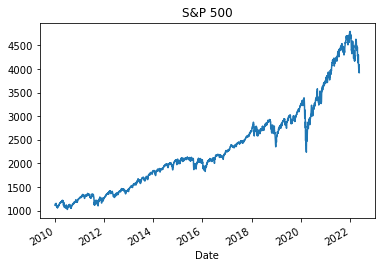

In [3]:
sp500_df['Close'].plot(title='S&P 500')

In [10]:
sp500_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-31,1126.599976,1127.640015,1114.810059,1115.099976,1115.099976,2076990000
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
...,...,...,...,...,...,...
2022-05-12,3903.949951,3964.800049,3858.870117,3930.080078,3930.080078,4964130000
2022-05-13,3963.899902,4038.879883,3963.899902,4023.889893,4023.889893,4142950000
2022-05-16,4013.020020,4046.459961,3983.989990,4008.010010,4008.010010,3824320000


In [4]:
sp500_df.reset_index()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-12-31,1126.599976,1127.640015,1114.810059,1115.099976,1115.099976,2076990000
1,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
3,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
4,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
...,...,...,...,...,...,...,...
3112,2022-05-12,3903.949951,3964.800049,3858.870117,3930.080078,3930.080078,4964130000
3113,2022-05-13,3963.899902,4038.879883,3963.899902,4023.889893,4023.889893,4142950000
3114,2022-05-16,4013.020020,4046.459961,3983.989990,4008.010010,4008.010010,3824320000
3115,2022-05-17,4052.000000,4090.719971,4033.929932,4088.850098,4088.850098,3846580000


In [21]:
sp500_df.reset_index().index

RangeIndex(start=0, stop=3117, step=1)

In [71]:
sp500_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3117 entries, 2009-12-31 to 2022-05-18
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3117 non-null   float64
 1   High       3117 non-null   float64
 2   Low        3117 non-null   float64
 3   Close      3117 non-null   float64
 4   Adj Close  3117 non-null   float64
 5   Volume     3117 non-null   int64  
 6   Mean       3117 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 194.8 KB


In [62]:
get_mean(x, 'high', 'low', 'mean')

ValueError: Wrong number of items passed 2, placement implies 1

In [74]:
x = pd.DataFrame(
    data=[[x*5,x] for x in range(4)],
    columns=['high','low']
)
print(x)
print(get_mean(x,'high','low','mean'))

   high  low
0     0    0
1     5    1
2    10    2
3    15    3
   high  low  mean
0     0    0   0.0
1     5    1   2.0
2    10    2   4.0
3    15    3   6.0


In [79]:
y = get_mean(x,'high','low','mean')
y['mean'].to_list()

[0.0, 2.0, 4.0, 6.0]

## Preprocessing
- Create Mean 
- Normalize Data
    - Fit on Train, Tranform Val and Test

In [56]:
def get_mean(df, high, low, mean):
    df[mean] = (df[high] - df[low]) / 2
    return df

def generate_time_sequence(df, col, seq_length):
    '''
    Get rolling sequence of length = seq_length, if remaining duration >= seq_length.
    Outputs a list of sequences. Each sequence is a list of [[x1,x2,x3],y4]
    '''
    df = df.reset_index()
    output = []
    for index in df.index:
        # Check if remaining sequence is of sufficient length
        if index + seq_length + 1 < df.index.stop:
            mini_seq = df[col].iloc[index:index+seq_length].to_list()
            output.append([mini_seq, df[col].iloc[index+seq_length]])
    return output

In [43]:
print(generate_time_sequence(sp500_df, "Close", 5))

[[[1115.0999755859375, 1132.989990234375, 1136.52001953125, 1137.1400146484375, 1141.68994140625], 1144.97998046875], [[1132.989990234375, 1136.52001953125, 1137.1400146484375, 1141.68994140625, 1144.97998046875], 1146.97998046875], [[1136.52001953125, 1137.1400146484375, 1141.68994140625, 1144.97998046875, 1146.97998046875], 1136.219970703125], [[1137.1400146484375, 1141.68994140625, 1144.97998046875, 1146.97998046875, 1136.219970703125], 1145.6800537109375], [[1141.68994140625, 1144.97998046875, 1146.97998046875, 1136.219970703125, 1145.6800537109375], 1148.4599609375], [[1144.97998046875, 1146.97998046875, 1136.219970703125, 1145.6800537109375, 1148.4599609375], 1136.030029296875], [[1146.97998046875, 1136.219970703125, 1145.6800537109375, 1148.4599609375, 1136.030029296875], 1150.22998046875], [[1136.219970703125, 1145.6800537109375, 1148.4599609375, 1136.030029296875, 1150.22998046875], 1138.0400390625], [[1145.6800537109375, 1148.4599609375, 1136.030029296875, 1150.22998046875, 1